## How to make a Transformer for time series forecasting with PyTorch
- https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.6.22</div>
<div style="text-align: right"> Last update: 2023.6.22</div>

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
# print(plt.stype.available)

# Options for pandas
pd.options.display.max_columns = 30

In [15]:
import torch
import torch.nn as nn
import math
from torch import Tensor

from typing import Tuple

In [3]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor

class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what 
    the positional encoding layer does and why it is needed:
    
    "Since our model contains no recurrence and no convolution, in order for the 
    model to make use of the order of the sequence, we must inject some 
    information about the relative or absolute position of the tokens in the 
    sequence." (Vaswani et al, 2017)
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=5000, 
        d_model: int=512,
        batch_first: bool=False
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        # adapted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        if self.batch_first:
            pe = torch.zeros(1, max_seq_len, d_model)
            
            pe[0, :, 0::2] = torch.sin(position * div_term)
            
            pe[0, :, 1::2] = torch.cos(position * div_term)
        else:
            pe = torch.zeros(max_seq_len, 1, d_model)
        
            pe[:, 0, 0::2] = torch.sin(position * div_term)
        
            pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)

“Deep Transformer Models for Time Series Forecasting: The Influenza Prevalence Case” 논문에서 소게된 구조를 구현함

![](2023-06-22-10-49-34.png)

![](2023-06-22-10-50-21.png)

위 그림에서 입력 레이어와 포지셔널 인코딩 레이어가 인코더의 일부로 표시되어 있고, 디코더 측에서는 입력 및 선형 매핑 레이어가 디코더의 일부로 표시되어 있다.

원본 트랜스포머 논문에서는 입력 레이어, 포지셔널 인코딩 레이어 및 선형 레이어가 인코더 및 디코더와 분리되어 있는 것으로 묘사되어 있다.

이 글에서는 원본 트랜스포머 논문에 따라 인코더와 디코더는 단지 n개의 스택형 인코더 또는 디코더 레이어로만 구성되며 다른 레이어는 인코더와 디코더 외부에 있는 별도의 레이어로 간주한다. 또한 원본 트랜스포머 논문에 따라 "추가 및 정규화" 작업을 레이어로 지칭하지 않는다.

![](2023-06-22-10-56-44.png)

본 노트북의 순서는 다음과 같다.

- 먼저 트랜스포머의 각 컴포넌트를 만드는 방법과 TimeSeriesTransformer라는 클래스에서 이 모든 것을 합치는 방법을 살펴본다.
- 그런 다음 모델에 제공되는 입력을 만드는 방법을 설명한다.

### 1. Decomposing the transformer architecture
#### 1.1. The encoder input layer

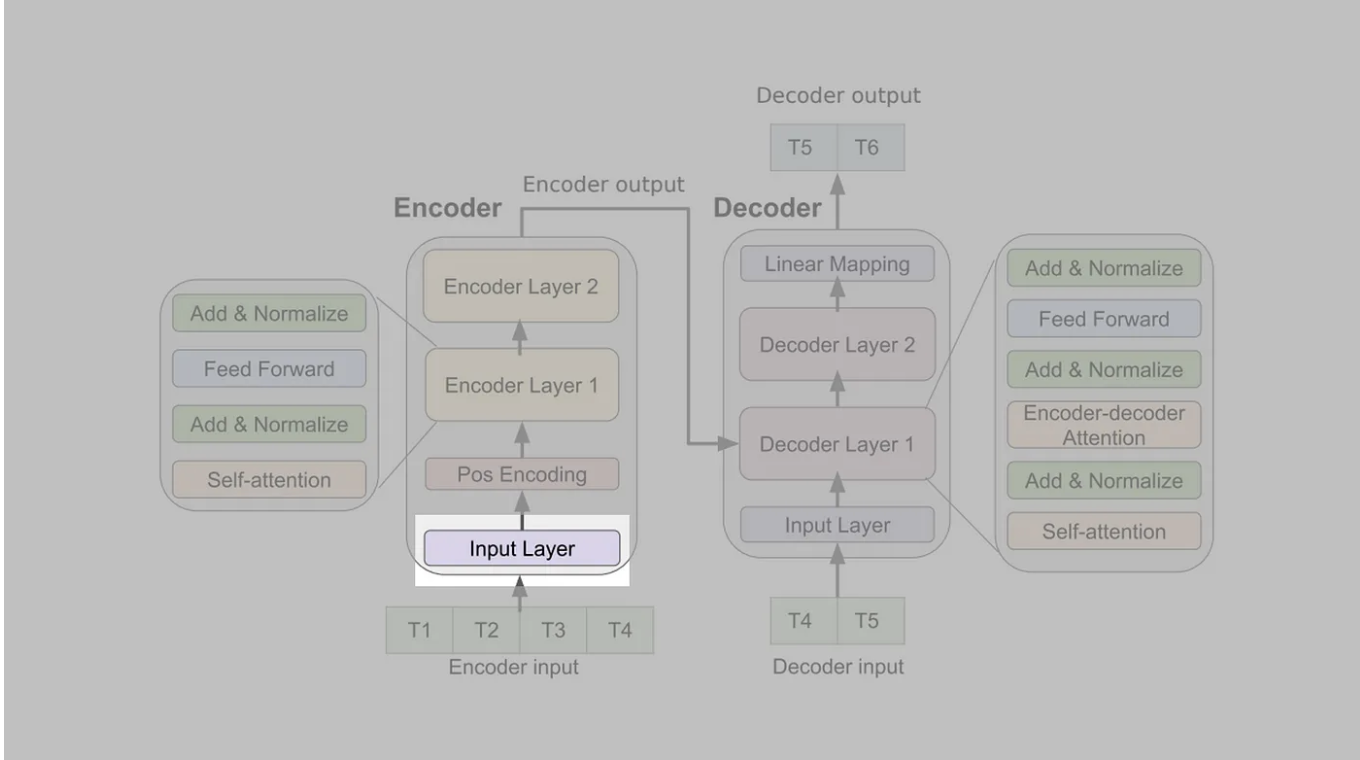

인코더 input은 nn.Linear로 구현가능. in_features 는 입력 변수의 수와 같아야 한다. univariate ts를 사용하려면 in_features = 1로 설정한다.   
out_feature는 하이퍼파라미터이며 논문에서는 512를 사용

```python
self.encoder_input_layer = nn.Linear(
  in_features=input_size, 
  out_features=dim_val
)
```

#### 1.2. The positional encoding layer

![](2023-06-22-11-08-39.png)

트랜스포머는 recurrent, conv를 사용하지 않는다. 따라서 시퀀스 순서정보를 사용하려면 시퀀스 내 토큰의 상대, 절대적 위치정보를 입력해야한다.

해당코드는 노트북 위애 클래스로 정의함

TimeSeriesTransformer안에서는 다음과 같이 사용함

```python
import positional_encoder as pe

# Create positional encoder
self.positional_encoding_layer = pe.PositionalEncoder(
    d_model=dim_val,
    dropout=dropout_pos_enc,
    max_seq_len=max_seq_len
    )
```

d_model은 dim_val 값을 사용한다.   
이렇게 설벙하면 인코더 레이어의 출력이 dim_val 사이즈로 되기 때문이다.(중요)

#### 1.3. Encoder layers

![](2023-06-22-11-15-17.png)

위 그림에는 인코더 레이어가 2개만 표시되어 있지만 실제로는 4개를 사용함.   
위 인코더는 원본 트랜스포머 인코더와 동일하므로 파이토치에서 import 하여 사용가능

먼저 torch.nn.TransformerEncoderLayer로 encoder_layer를 선언한다.  

```python
encoder_layer = torch.nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
```

torch.nn.TransformerEncoderLayer는 셀프 어텐션 레이어를 가지고 위 그림과 같이 사이에 add & normalize, feed forward 레이어기 끼게 된다.  
하지만 별도로 클래스를 만들지 않는다.     

norm은 optional parameter로 설정할 수 있다.  
nn.TransformerEncoderLayer 클래스를 사용할 때는 각 레이어마다 nn.TransformerEncoderLayer가 이미 정규화되므로 정규화 객체를 전달하는 것이 중복된다는 점에 유의해야한다. 따라서 어텐션 후단은 norm을 None으로 설정해야한다.

```python
# Create an encoder layer
encoder_layer = nn.TransformerEncoderLayer(
    d_model=dim_val,
    nhead=n_heads, 
    batch_first=True
    )

# Stack the encoder layer n times in nn.TransformerDecoder
self.encoder = nn.TransformerEncoder(
    encoder_layer=encoder_layer,
    num_layers=n_encoder_layers, 
    norm=None
)
```

#### 1.4. The decoder input layer

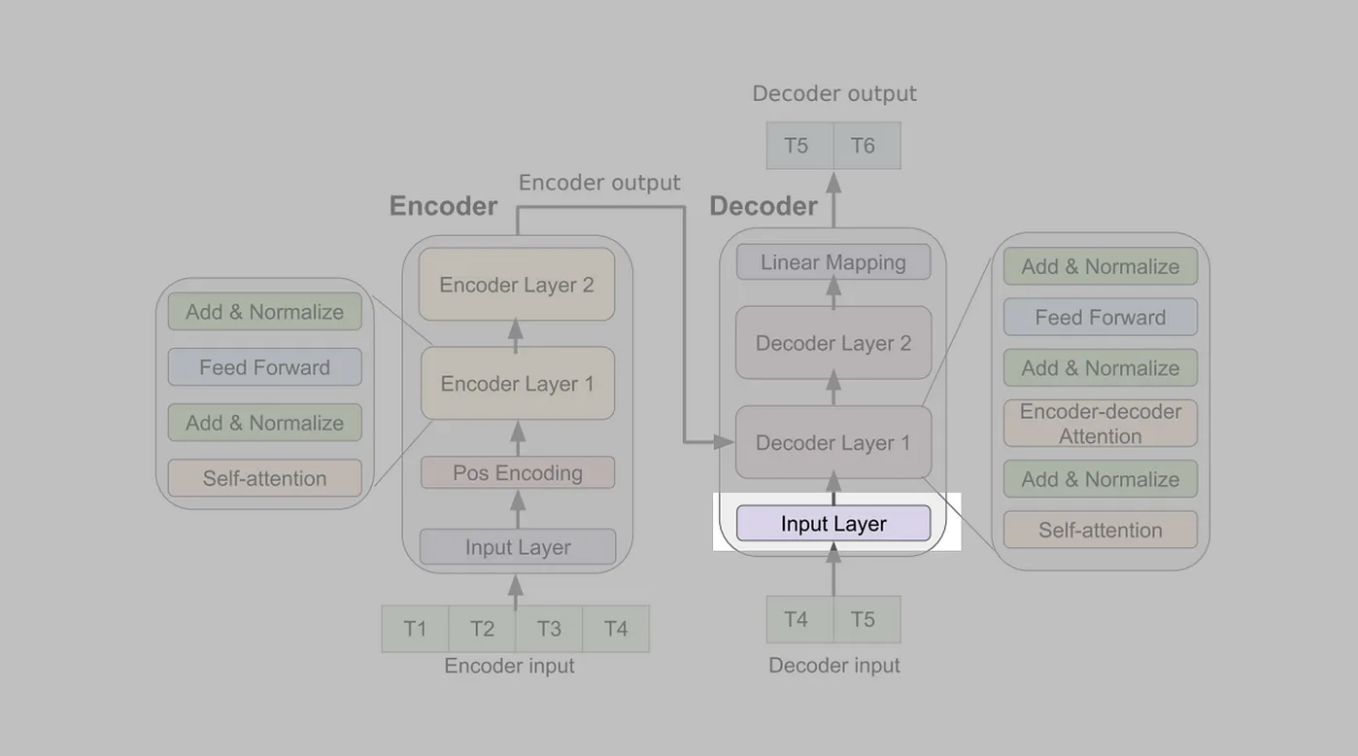

디코더 입력 레이어는 인코더 입력 레이어와 마찬가지로 단순한 선형 레이어이다.  
인수는 모델에 입력으로 사용하는 변수의 수와 같아야 한다.  
단변량 시계열 예측 문제에서 in_features = 1이다.(타겟이 한종류)  
out_features 인수는 512 값을 갖는 하이퍼파라미터인 d_model이다.

```python
self.decoder_input_layer = nn.Linear(
  in_features=num_predicted_features, # the number of features you want to predict. Usually just 1 
  out_features=dim_val
) 
```

#### 1.5. Decoder layers

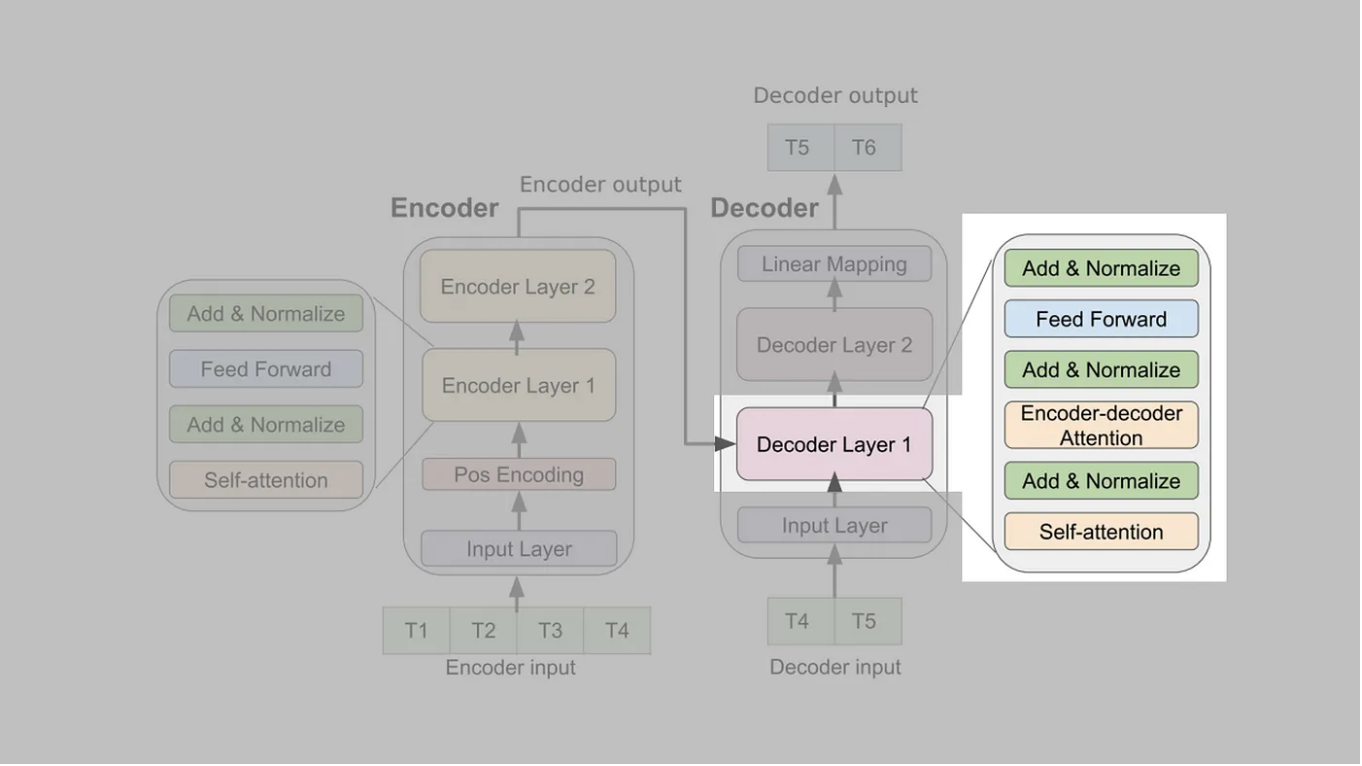

다이어그램에는 2개의 디코더 레이어만 표시되어 있지만, 작성자는 실제로 4개의 디코더 레이어를 사용한다.
디코더는 인코더와 정확히 동일한 방식으로 만들어지며, num_layers가 4개이다.

헤드 수는 명시되어 있지 않으므로 nheads=8을 사용한다.

```python
# Create the decoder layer
decoder_layer = nn.TransformerDecoderLayer(
  d_model=dim_val, 
  nhead=n_heads,
  batch_first=True
  )

# Stack the decoder layer n times
self.decoder = nn.TransformerDecoder(
  decoder_layer=decoder_layer,
  num_layers=n_decoder_layers, 
  norm=None
  )
```

#### 1.6. Linear mapping layer

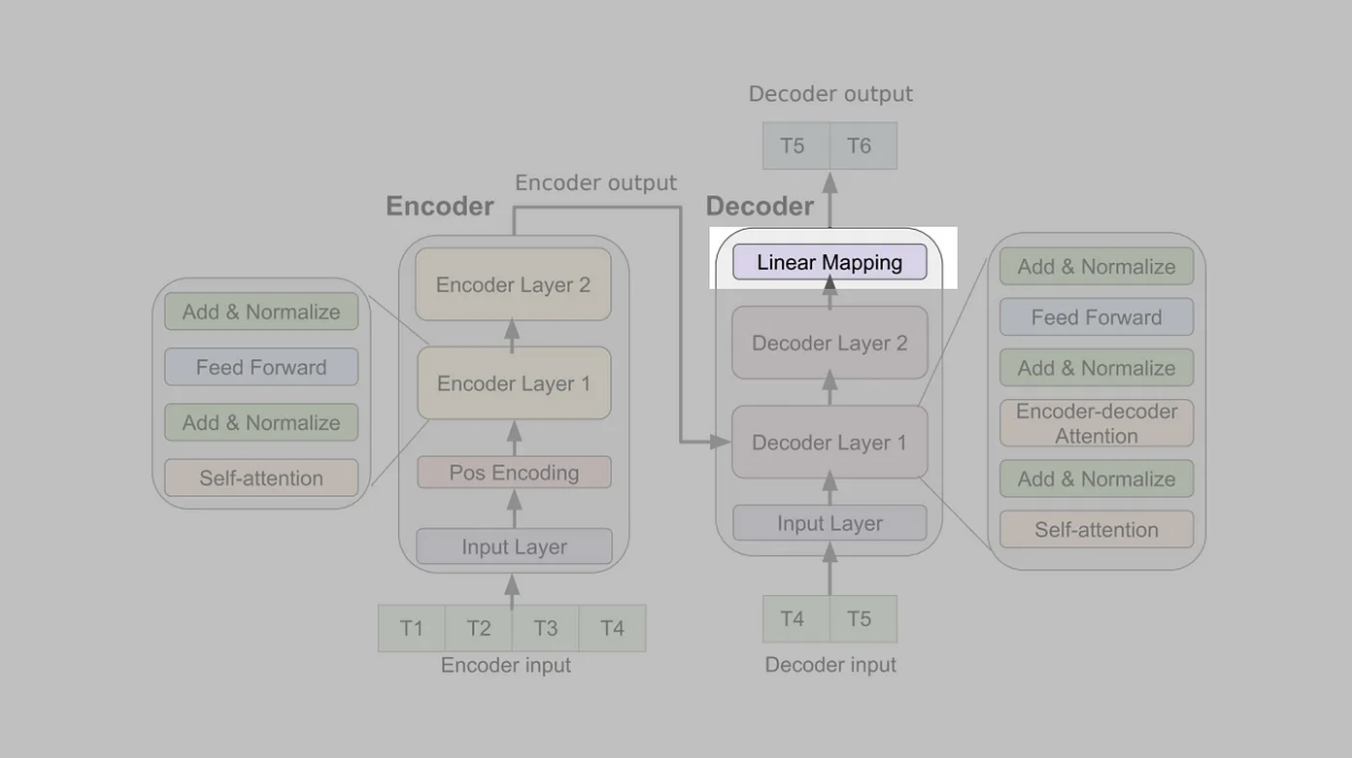

이 레이어를 "linear mapping layer"라고 부르지만, 인수의 값을 제외하면 인코더 및 디코더 입력 레이어와 실제로는 동일하다.  
인수의 값은 디코더의 출력을 수용하기 위해 출력 시퀀스 길이에 d_model을 곱한 값과 같아야 한다.

선형 매핑 레이어가 트랜스포머 모델의 최종 레이어이므로 OUT_Features는 타겟 시퀀스 길이와 같아야 한다.  
따라서 시계열 데이터 세트가 시간별 데이터 포인트로 구성되어 있고 24시간 앞을 예측하려는 경우, out_features는 24가 되어야 한다.|

```python
self.linear_mapping = nn.Linear(
  in_features=dim_val,
  out_features=num_predicted_features
  )
```

전체를 클래스로 구현

In [4]:
import torch.nn as nn
from torch import Tensor

import torch.nn.functional as F

In [11]:
class TimeSeriesTransformer(nn.Module):
    """
    This class implements a transformer model that can be used for times series
    forecasting. This time series transformer model is based on the paper by
    Wu et al (2020) [1]. The paper will be referred to as "the paper".
    A detailed description of the code can be found in my article here:
    https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e
    In cases where the paper does not specify what value was used for a specific
    configuration/hyperparameter, this class uses the values from Vaswani et al
    (2017) [2] or from PyTorch source code.
    Unlike the paper, this class assumes that input layers, positional encoding 
    layers and linear mapping layers are separate from the encoder and decoder, 
    i.e. the encoder and decoder only do what is depicted as their sub-layers 
    in the paper. For practical purposes, this assumption does not make a 
    difference - it merely means that the linear and positional encoding layers
    are implemented inside the present class and not inside the 
    Encoder() and Decoder() classes.
    [1] Wu, N., Green, B., Ben, X., O'banion, S. (2020). 
    'Deep Transformer Models for Time Series Forecasting: 
    The Influenza Prevalence Case'. 
    arXiv:2001.08317 [cs, stat] [Preprint]. 
    Available at: http://arxiv.org/abs/2001.08317 (Accessed: 9 March 2022).
    [2] Vaswani, A. et al. (2017) 
    'Attention Is All You Need'.
    arXiv:1706.03762 [cs] [Preprint]. 
    Available at: http://arxiv.org/abs/1706.03762 (Accessed: 9 March 2022).
    """
    def __init__(self,
                 input_size: int,
                 dec_seq_len: int,
                 batch_first: bool,
                 out_seq_len: int= 58,
                 dim_val: int = 512,
                 n_encoder_layers: int = 4,
                 n_decoder_layers: int = 4,
                 n_heads: int = 8,
                 dropout_encoder: float=0.2, 
                 dropout_decoder: float=0.2,
                 dropout_pos_enc: float=0.1,
                 dim_feedforward_encoder: int=2048,
                 dim_feedforward_decoder: int=2048,
                 num_predicted_features: int=1
                 ):
        """
        Args:
            input_size: int, 입력 변수 사이즈. 단변량일경우 1
            dec_seq_len: int, 디코더로 주입될 입력 시퀀스 길이
            dim_val: int, d_model. 모든 서브레이어의 출력이 dim_val 차원을 가지게됨
            n_encoder_layers: int, 인코더 스택 수
            n_decoder_layers: int, 디코더 스택 수
            n_heads: int, 어텐션 헤드 수 (병렬 어텐션 레이어 수)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, 인코더 선형 레이어 뉴런 수
            dim_feedforward_decoder: int, 디코더 선형 레이어 뉴런 수
            num_predicted_features: int, 예측하고자 하는 피처의 수
                                    모델하나로 여러개의 피처를 예측하고자 한다면 1보다 큰 값을 가진다.
        """
        
        super().__init__()
        
        self.dec_seq_len = dec_seq_len
        
        #print("input_size is: {}".format(input_size))
        #print("dim_val is: {}".format(dim_val))
        
        self.encoder_input_layer = nn.Linear(
            in_features = input_size,
            out_features = dim_val
        )
        
        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features
            )
        
        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )
        
        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model = dim_val,
            nhead= n_heads,
            dim_feedforward = dim_feedforward_encoder,
            dropout = dropout_encoder,
            batch_first = batch_first
        )
        
        # Stack the encoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )
        
        
    def forward(self, 
                src: Tensor,
                tgt: Tensor,
                src_mask: Tensor = None,
                tgt_mask: Tensor = None,
                ) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """
        
        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        #print("From model.forward(): tgt size = {}".format(tgt.size()))
        
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        
        src = self.positional_encoding_layer(src)# src shape: [batch_size, src length, dim_val]
        
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        
        
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val]
        
        decoder_output = self.decoder( # output shape: [batch_size, target seq len, dim_val]
            tgt = decoder_output,
            memory = src, # ??
            tgt_mask = tgt_mask,
            memory_mask = src_mask
        )
        
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        #print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))

        return decoder_output

모델 초기화

In [12]:
## Model parameters
dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 1 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 92 # length of input given to decoder. Can have any integer value.
enc_seq_len = 153 # length of input given to encoder. Can have any integer value.
output_sequence_length = 58 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder


In [13]:
model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    batch_first=True,
    dec_seq_len=dec_seq_len,
    #max_seq_len=max_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads)

In [14]:
model

TimeSeriesTransformer(
  (encoder_input_layer): Linear(in_features=1, out_features=512, bias=True)
  (decoder_input_layer): Linear(in_features=1, out_features=512, bias=True)
  (linear_mapping): Linear(in_features=512, out_features=1, bias=True)
  (positional_encoding_layer): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout

### 2. How to create the inputs for a transformer model

입력은 다음과 같다.  
src, trg, src_mask, trg_mask


#### 2.1. How to create src and trg for a time series transformer model

src는 인코더 입력이며 "소스"의 줄임말입니다. src는 단순히 전체 시퀀스에서 연속된 데이터 포인트의 하위 집합입니다. src의 길이에 따라 모델이 예측을 할 때 고려하는 과거 데이터 포인트의 수가 결정됩니다. 데이터 집합의 시간별 해상도가 있는 경우 하루에 24개의 데이터 포인트가 있으며, 모델이 지난 이틀간의 데이터를 기반으로 예측을 수행하려면 src의 길이는 48이어야 합니다.   

trg는 디코더 입력입니다. Trg는 "target"의 줄임말이지만 실제 타겟 시퀀스가 아니라 src의 마지막 데이터 포인트와 그 마지막 데이터 포인트를 제외한 실제 타겟 시퀀스의 모든 데이터 포인트로 구성된 시퀀스이기 때문에 약간 오해의 소지가 있습니다. 이것이 사람들이 때때로 trg 시퀀스를 "오른쪽으로 시프트된" 시퀀스라고 부르는 이유입니다. trg의 길이는 실제 타겟 시퀀스의 길이와 같아야 합니다. 때때로 tgt라는 용어가 동의어로 사용되는 것을 볼 수 있습니다.

일반적인 훈련 설정에서는 10개의 후행 주간 데이터 포인트에서 4개의 미래 주간 ILI 비율을 예측하도록 모델을 훈련합니다.   
즉, 인코더 입력(x1, x2, ..., x10)과 디코더 입력(x10, ..., x13)이 주어지면 디코더는 (x11, ..., x14)를 출력하는 것을 목표로 합니다.

다음은 시퀀스가 주어지면 실제 목표 시퀀스인 trg_y뿐만 아니라 src와 trg를 생성하는 함수입니다. src 및 trg 객체는 모델에 입력되며, trg_y는 손실을 계산할 때 모델의 출력을 비교할 대상 시퀀스입니다. get_src_trg() 함수에 주어진 시퀀스는 전체 데이터 집합의 하위 시퀀스여야 하며 입력_시퀀스_길이 + 대상_시퀀스_길이가 있어야 합니다.

다음은 src, trg, trg_y를 생성하는 함수입니다:

In [16]:
def get_src_trg(
    self,
    sequence: torch.Tensor,
    enc_seq_len: int,
    target_seq_len: int

) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    
    """
    Generate the src (encoder input), trg (decoder input) and trg_y (the target) sequences from a sequence. 
    Args:
        sequence: tensor, a 1D tensor of length n where 
                    n = encoder input length + target sequence length  
        enc_seq_len: int, the desired length of the input to the transformer encoder
        target_seq_len: int, the desired length of the target sequence (the 
                            one against which the model output is compared)
    Return: 
        src: tensor, 1D, used as input to the transformer model
        trg: tensor, 1D, used as input to the transformer model
        trg_y: tensor, 1D, the target sequence against which the model output is compared when computing loss. 
    """
    
    assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"
    
    src = sequence[: enc_seq_len]
    
    # decoder input. As per the paper, it must have the same dimension as the 
    # target sequence, and it must contain the last value of src, and all
    # values of trg_y except the last (i.e. it must be shifted right by 1)
    
    trg = sequence[enc_seq_len -1:len(sequence) -1]
    
    trg = trg[:, 0] #???
    
    if len(trg.shape) == 1:
        trg = trg.unsqeeze(-1)
        
    assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"
    
    trg_y = sequence[-target_seq_len:]
    
    trg_y = trg_y[:, 0]
    
    assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

    return src, trg, trg_y.squeeze(-1) # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len] 

#### 2.2. Masking the decoder input in transformers

이제 모델의 forward()메서드에 필요한 두 개의 첫 번째 입력을 생성하는 방법을 살펴봤습니다. 이제 모델의 forward() 메서드에 필요한 마지막 두 입력인 src_mask와 trg_mask를 고려해 보겠습니다.

그런데 두가지 타입의 마스킹이 존재한다.  
- padding masking : 길이가 다른 시퀀스를 사용하는 경우(일반적으로 문장의 길이가 다를 수 있음) 선택한 최대 시퀀스 길이보다 짧은 시퀀스(모든 값을 가질 수 있는 하이퍼파라미터, 예: 50)는 패딩 토큰으로 패딩됩니다. 패딩 토큰은 모델이 이러한 토큰을 인식하지 못하도록 마스킹해야 합니다.   
- decoder input masking(look ahead masking) : 디코더가 토큰 t의 '의미'를 '고려'할 때 미래의 토큰을 고려하지 못하도록 합니다.

이 글에서는 모든 시퀀스의 길이가 동일하도록 커스텀 데이터셋 클래스를 구현할 것이므로 시퀀스를 패딩하지 않겠습니다. 따라서 우리의 경우 패딩 마스킹이 필요하지 않으며[8], 인코더 입력을 마스킹할 필요가 없습니다[9].

그러나 디코더 입력 마스킹을 사용해야 합니다.

디코더는 두종류의 입력을 받는다.  
- 인코더 출력
- 디코더 입력

이 입력을 마스킹하기 위해 두게의 마스킹 텐서를 추가한다.  
- src_mask : 인코더 출력을 마스킹
- trg_mask : 디코더 입력을 마스킹

src_mask는 [target sequence length, encoder sequence length] 사이즈여야 하고,  
trg_mask는 [target sequence length, target sequence length] 사이즈여야 한다.

In [17]:
def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

In [18]:
# Input length
enc_seq_len = 100

# Output length
output_sequence_length = 58

In [20]:
tgt_mask = generate_square_subsequent_mask(
    dim1 = output_sequence_length,
    dim2 = output_sequence_length 
)

src_mask = generate_square_subsequent_mask(
    dim1 = output_sequence_length,
    dim2 = enc_seq_len
)

In [22]:
tgt_mask.shape

torch.Size([58, 58])

In [23]:
src_mask.shape

torch.Size([58, 100])

```python
output = model(
    src=src, 
    tgt=trg,
    src_mask=src_mask,
    tgt_mask=tgt_mask
    )
```

### What inputs does the time series Transformer model require?

트랜스포머 모델은 다음 입력을 필요로 한다.  

src는 인코더에서 사용한다. src의 형태는 [배치 크기, n, 입력 피처 수] 또는 [n, 배치 크기, 입력 피처 수](batch_first 인자에 따라 다름)여야 하며, 여기서 n은 입력 시퀀스의 데이터 포인트 수입니다. 예를 들어 시간별 전기 요금을 예측하는 경우 지난 주 데이터를 기반으로 예측을 하려면 n=168(24*7)이 됩니다.   

tgt는 디코더에 사용되는 입력이다.   
tgt는 src에 있는 입력 시퀀스의 마지막 값과 타겟 시퀀스의 마지막 값을 제외한 모든 값으로 구성된다.  
즉, [배치 크기, m, predicted variable 수] 또는 [m, 배치 크기, predicted variable 수]의 형태를 가지게 되며, 여기서 m은 예측 기간입니다. 전기 가격 예측의 예를 계속 이어서, 48시간 이후 기간의 전기 가격을 예측하려는 경우 m=48이 됩니다.


### How to use a time series Transformer for inference

학습 중에는 타겟 시퀀스 값을 알고 있기 때문에 tgt를 생성하는 것이 간단하다.  
그러나 프로덕션 환경과 같이 추론하는 동안에는 당연히 예측을 할 때 대상 시퀀스의 값을 알지 못합니다. 
그렇지 않다면 애초에 예측을 할 필요가 없기 때문입니다. 따라서 추론 중에 모델에 입력으로 사용할 수 있는 합리적인 tgt를 생성할 수 있는 방법을 찾아야 합니다.

이제 시계열 트랜스포머에 어떤 입력이 필요한지, 어떻게든 tgt를 생성해야 하는 이유를 알았으니 실제로 어떻게 생성하는지 살펴보겠습니다.  
다음에서는 전체적인 목적은 tgt 텐서를 생성하는 것이며, 생성된 텐서는 예측을 위해 모델에 입력으로 사용할 수 있다는 점을 명심하세요.

간단한 예를 들어 설명하기 위해 추론 시점인 t에서 시퀀스의 가장 최근 관측치 5개를 기반으로 시퀀스의 다음 3개 값을 예측하고자 한다고 가정해 보겠습니다.

src = [xt-4, xt-3, xt-2, xt-1, xt]   
tgt_y = [xt+1, xt+2, xt+3]    

따라서 모델이 tgt_y에 대한 예측을 수행하기 위해 입력으로 필요한 tgt 는 다음과 같아야 합니다:  
tgt = [xt, xt+1, xt+2]

xt의 값은 알지만 xt+1이나 xt+2의 값은 모르기 때문에 어떻게든 이를 추정해야 합니다.  
이 게시물에서는 먼저 xt+1 을 예측한 다음 이 예측값을 tgt에 추가하여 tgt = [xt, xt+1]이 되도록 한 다음 이 tgt를 사용하여 xt+2 를 예측한 다음 이 예측값을 tgt에 추가하여 tgt = [xt, xt+1, xt+2]가 되도록 하고 마지막으로 이 tgt를 사용하여 최종 예측값을 생성하는 방식으로 수행합니다.

아래 함수는 파이토치에서 시계열 트랜스포머 모델로 추론을 실행하는 데 필요한 코드입니다. 이 함수는 위에서 설명한 접근 방식에 따라 예측을 생성합니다. 문서에 설명된 몇 가지 다른 인수와 함께 Transformer 모델과 src를 전달합니다. 그런 다음 이 함수는 tgt를 반복적으로 생성하고 t 시점에 마지막으로 알려진 관측치와 나머지 m-1 데이터 포인트에 대한 추정 값으로 구성된 tgt를 기반으로 최종 예측을 생성합니다.

In [ ]:
def run_encoder_decoder_inference(
    model: nn.Module,
    src: torch.Tensor,
    forecast_window: int,
    batch_size: int,
    device,
    batch_first: bool=False
) -> torch.Tensor:
    """
    NB! This function is currently only tested on models that work with 
    batch_first = False
    
    This function is for encoder-decoder type models in which the decoder requires
    an input, tgt, which - during training - is the target sequence. During inference,
    the values of tgt are unknown, and the values therefore have to be generated
    iteratively.  
    
    This function returns a prediction of length forecast_window for each batch in src
    
    NB! If you want the inference to be done without gradient calculation, 
    make sure to call this function inside the context manager torch.no_grad like:
    with torch.no_grad:
        run_encoder_decoder_inference()
        
    The context manager is intentionally not called inside this function to make
    it usable in cases where the function is used to compute loss that must be 
    backpropagated during training and gradient calculation hence is required.
    
    If use_predicted_tgt = True:
    To begin with, tgt is equal to the last value of src. Then, the last element
    in the model's prediction is iteratively concatenated with tgt, such that 
    at each step in the for-loop, tgt's size increases by 1. Finally, tgt will
    have the correct length (target sequence length) and the final prediction
    will be produced and returned.
    
    Args:
        model: An encoder-decoder type model where the decoder requires
               target values as input. Should be set to evaluation mode before 
               passed to this function.
               
        src: The input to the model
        
        forecast_horizon: The desired length of the model's output, e.g. 58 if you
                         want to predict the next 58 hours of FCR prices.
                           
        batch_size: batch size
        
        batch_first: If true, the shape of the model input should be 
                     [batch size, input sequence length, number of features].
                     If false, [input sequence length, batch size, number of features]
    
    """
    
    